<a href="https://colab.research.google.com/github/alerosenberg/rais_ale/blob/main/MODELO_RAIS_BQ_2803.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#STEP-1: Import libraries
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import files
from oauth2client.client import GoogleCredentials
import glob
#STEP-2: Autheticate E-Mail ID
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import pandas as pd
from google.cloud import bigquery
import numpy as np 
!pip install linearmodels
from linearmodels import PanelOLS
!pip install -q xlrd

In [ ]:
df_estab1 = pd.io.gbq.read_gbq('''
Select 
ano,
cnae_1,
indicador_simples,
id_municipio_6,
count(*) as qtd_empresas
 from `basedosdados.br_me_rais.microdados_estabelecimentos`
where sigla_uf in ('SP')
and ano between 2000 and 2005
and indicador_rais_negativa = 0
group by 1,2,3,4
  # LIMIT 100
''', project_id='aledados')

In [ ]:
df_estab = pd.io.gbq.read_gbq('''
Select 
ano,
cnae_2,
indicador_simples,
id_municipio_6,
count(*) as qtd_empresas
 from `basedosdados.br_me_rais.microdados_estabelecimentos`
where sigla_uf in ('SP')
and ano between 2006 and 2019
and indicador_rais_negativa = 0
and cnae_2 <> '00000-1'
group by 1,2,3,4
  # LIMIT 100
''', project_id='aledados')

In [ ]:
df_vinc11 = pd.io.gbq.read_gbq('''
Select 
ano,
cnae_1,
indicador_simples,
id_municipio_6,
avg(valor_remun_media_nominal) as rem_med,
count(vinculo_ativo_3112) as empregados_ativos
from `basedosdados.br_me_rais.microdados_vinculos`
where sigla_uf in ('SP')
and ano between 2004 and 2005
and vinculo_ativo_3112 > 0 and valor_remun_media_nominal > 0
group by 1,2,3,4
  # LIMIT 100
''', project_id='aledados')

In [ ]:
df_vinc1 = pd.io.gbq.read_gbq('''
Select 
ano,
cnae_1,
indicador_simples,
id_municipio_6,
avg(valor_remun_media_nominal) as rem_med,
count(vinculo_ativo_3112) as empregados_ativos
from `basedosdados.br_me_rais.microdados_vinculos`
where sigla_uf in ('SP')
and ano between 2000 and 2003
and vinculo_ativo_3112 > 0 and valor_remun_media_nominal > 0
group by 1,2,3,4
  # LIMIT 100
''', project_id='aledados')

In [ ]:
df_vinc = pd.io.gbq.read_gbq('''
Select 
ano,
cnae_2,
indicador_simples,
id_municipio_6,
avg(valor_remun_media_nominal) as rem_med,
count(vinculo_ativo_3112) as empregados_ativos
from `basedosdados.br_me_rais.microdados_vinculos`
where sigla_uf in ('SP')
and ano between 2006 and 2019
and vinculo_ativo_3112 > 0 and valor_remun_media_nominal > 0
and cnae_2 <> '00000-1'
group by 1,2,3,4
  # LIMIT 100
''', project_id='aledados')

In [ ]:
result = pd.merge(df_estab, df_vinc, how="left", on=["ano","cnae_2","indicador_simples","id_municipio_6"])

In [ ]:
df_vinc1f = pd.concat([df_vinc1, df_vinc11])

In [ ]:
result1 = pd.merge(df_estab1, df_vinc1f, how="left", on=["ano","cnae_1","indicador_simples","id_municipio_6"])

In [ ]:
result['rem_med_log'] = np.log(result['rem_med']) 
result['empregados_ativos_log'] = np.log(result['empregados_ativos']) 
result['qtd_empresas_log'] = np.log(result['qtd_empresas'])

In [ ]:
result1['rem_med_log'] = np.log(result1['rem_med']) 
result1['empregados_ativos_log'] = np.log(result1['empregados_ativos']) 
result1['qtd_empresas_log'] = np.log(result1['qtd_empresas']) 

In [ ]:
file_id = '17ZpMaBNGB_Agzq9fg_8kDJWONfJzg2up'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('CNAE_1_CNAE_2_final.xlsx')

In [ ]:
base_cnae1_cnae2 = pd.read_excel('CNAE_1_CNAE_2_final.xlsx')

In [ ]:
result1['cnae_1'] = result1['cnae_1'].astype(str).astype(int)
result11 = pd.merge(result1, base_cnae1_cnae2, how="inner", on=["cnae_1"])

In [ ]:
result['cnae_2_municipio'] = result['cnae_2'].map(str)+result['id_municipio_6'].map(str)

In [ ]:
result11['cnae_2_municipio'] = result11['cnae_2'].map(str)+result11['id_municipio_6'].map(str)

In [ ]:
result_base_completa = pd.concat([result, result11])

In [ ]:
# from google.colab import drive
# drive.mount('drive')

In [ ]:
# result_base_completa.to_csv('result_base_completa.csv')
# !cp result_base_completa.csv "drive/My Drive/"

In [3]:
file_id = '1-26iLkKkxb0DbIEeYFlwfbBAyFeSBxim'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('result_base_completa.csv')

In [4]:
result_base_completa_imp = pd.read_csv('result_base_completa.csv')

In [5]:
result_base_completa_imp = result_base_completa_imp.loc[:, ~result_base_completa_imp.columns.str.contains('^Unnamed')]

In [6]:
file_id = '1pM28PfsKerRGIDn5tf0FCVtK350138Br'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('BASE_MODELO.xlsx')

In [7]:
base_modelo = pd.read_excel('BASE_MODELO.xlsx')

In [8]:
result_base_completa_imp['ano']=result_base_completa_imp['ano'].astype(int)
result_base_completa_imp['cnae_2']=result_base_completa_imp['cnae_2'].astype(int)

In [9]:
result_base = pd.merge(result_base_completa_imp, base_modelo, how="left", on=["ano","cnae_2"])

In [ ]:
# result_base.count()
# 1.946,994

In [ ]:
result_base.drop(columns=['cnae_1', 'TRATADA'])

In [12]:
result_base.head()

,ano,cnae_2,indicador_simples,id_municipio_6,qtd_empresas,rem_med,empregados_ativos,rem_med_log,empregados_ativos_log,qtd_empresas_log,cnae_2_municipio,cnae_1,TRATADA,DESC_CNAE2_5D,ATIVIDADE_CONTA_NACIONAL,DESC_ATIVIDADE,SETOR_COM_ST,ST_CNAE_CNAE,DUMMY_ST_CNAE,DUMMY_ST_PRE08,DUMMY_ST_POS08,SETOR,DUMMY_PRIMARIO,DUMMY_SECUNDARIO,DUMMY_TERCIARIO,PERC_ATIV_ST,DUMMY_MI_08,O_ST_QTD_EMP,D_ST_QTD_EMP,O_ST_REM_EMP,D_ST_REM_EMP,O_ST_VIN_EMP,D_ST_VIN_EMP
0,2007,14126,1,350010,21,513.117463,410.0,6.240505,6.016157,3.044522,14126350010,NaN,NaN,"Confecção de peças do vestuário, exceto roupas...",1400,Confecção de artefatos do vestuário e acessórios,0,SEM ST,0,0,0,Secundário,0,1,0,0.000000,0,0.096603,0.037591,0.117578,0.035275,0.092100,0.035364
1,2007,47890,0,350010,9,777.248788,33.0,6.655760,3.496508,2.197225,47890350010,NaN,NaN,Comércio varejista de outros produtos novos nã...,4680,"Comércio por atacado e a varejo, exceto veícul...",0,SEM ST,0,0,0,Terciário,0,0,1,0.000000,0,0.156603,0.451810,0.131751,0.411084,0.146189,0.446100
2,2007,1512,0,350010,109,550.124032,124.0,6.310144,4.820282,4.691348,1512350010,NaN,NaN,Criação de bovinos,192,"Pecuária, inclusive o apoio à pecuária",1,PÓS 2008,1,0,1,Primário,1,0,0,0.856023,0,0.525097,0.934996,0.448924,0.900783,0.493599,0.922489
3,2007,47814,1,350010,53,539.237429,105.0,6.290156,4.653960,3.970292,47814350010,NaN,NaN,Comércio varejista de artigos do vestuário e a...,4680,"Comércio por atacado e a varejo, exceto veícul...",0,SEM ST,0,0,0,Terciário,0,0,1,0.000000,0,0.156603,0.451810,0.131751,0.411084,0.146189,0.446100
4,2007,47539,1,350010,4,738.043333,15.0,6.604003,2.708050,1.386294,47539350010,NaN,NaN,Comércio varejista especializado de eletrodomé...,4680,"Comércio por atacado e a varejo, exceto veícul...",0,SEM ST,0,0,0,Terciário,0,0,1,0.000000,0,0.156603,0.451810,0.131751,0.411084,0.146189,0.446100


In [13]:
result_base.sort_values(['cnae_2_municipio','indicador_simples','ano'])

,ano,cnae_2,indicador_simples,id_municipio_6,qtd_empresas,rem_med,empregados_ativos,rem_med_log,empregados_ativos_log,qtd_empresas_log,cnae_2_municipio,cnae_1,TRATADA,DESC_CNAE2_5D,ATIVIDADE_CONTA_NACIONAL,DESC_ATIVIDADE,SETOR_COM_ST,ST_CNAE_CNAE,DUMMY_ST_CNAE,DUMMY_ST_PRE08,DUMMY_ST_POS08,SETOR,DUMMY_PRIMARIO,DUMMY_SECUNDARIO,DUMMY_TERCIARIO,PERC_ATIV_ST,DUMMY_MI_08,O_ST_QTD_EMP,D_ST_QTD_EMP,O_ST_REM_EMP,D_ST_REM_EMP,O_ST_VIN_EMP,D_ST_VIN_EMP
1784479,2002,1113,0,350010,1,244.070000,1.0,5.497455,0.000000,0.000000,1113350010,1112.0,0.0,Cultivo de cereais,191,"Agricultura, inclusive o apoio à agricultura e...",1,SEM ST,0,0,0,Primário,1,0,0,0.214224,0,0.413567,0.796357,0.386460,0.765071,0.426215,0.784084
1784799,2003,1113,0,350010,1,266.800000,1.0,5.586499,0.000000,0.000000,1113350010,1112.0,0.0,Cultivo de cereais,191,"Agricultura, inclusive o apoio à agricultura e...",1,SEM ST,0,0,0,Primário,1,0,0,0.226728,0,0.421717,0.796519,0.387484,0.762375,0.440679,0.788063
1785800,2005,1113,0,350010,2,325.000000,3.0,5.783825,1.098612,0.693147,1113350010,1112.0,0.0,Cultivo de cereais,191,"Agricultura, inclusive o apoio à agricultura e...",1,SEM ST,0,0,0,Primário,1,0,0,0.227612,0,0.434250,0.797640,0.391557,0.763648,0.431741,0.787863
95229,2006,1113,0,350010,1,490.240000,1.0,6.194895,0.000000,0.000000,1113350010,NaN,NaN,Cultivo de cereais,191,"Agricultura, inclusive o apoio à agricultura e...",1,SEM ST,0,0,0,Primário,1,0,0,0.265037,0,0.436178,0.787496,0.393647,0.759436,0.428649,0.785687
136,2007,1113,0,350010,1,NaN,NaN,NaN,NaN,0.000000,1113350010,NaN,NaN,Cultivo de cereais,191,"Agricultura, inclusive o apoio à agricultura e...",1,SEM ST,0,0,0,Primário,1,0,0,0.255476,0,0.435967,0.782090,0.397634,0.750617,0.425270,0.783639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87124,2007,99008,0,355250,1,449.633333,6.0,6.108432,1.791759,0.000000,99008355250,NaN,NaN,Organismos internacionais e outras instituiçõe...,9480,Organizações associativas e outros serviços pe...,0,SEM ST,0,0,0,Terciário,0,0,1,0.000000,0,0.101248,0.154363,0.089991,0.142685,0.096529,0.151399
927305,2008,99008,0,355280,1,1407.515000,2.0,7.249581,0.693147,0.000000,99008355280,NaN,NaN,Organismos internacionais e outras instituiçõe...,9480,Organizações associativas e outros serviços pe...,0,SEM ST,0,0,0,Terciário,0,0,1,0.000000,1,0.101248,0.154777,0.089991,0.145469,0.096529,0.153388
833371,2016,99008,0,355620,1,2884.965758,33.0,7.967268,3.496508,0.000000,99008355620,NaN,NaN,Organismos internacionais e outras instituiçõe...,9480,Organizações associativas e outros serviços pe...,0,SEM ST,0,0,0,Terciário,0,0,1,0.000000,1,0.099958,0.155651,0.090865,0.147688,0.093661,0.160818
1929558,2004,99008,0,355730,1,280.000000,1.0,5.634790,0.000000,0.000000,99008355730,99007.0,0.0,Organismos internacionais e outras instituiçõe...,9480,Organizações associativas e outros serviços pe...,0,SEM ST,0,0,0,Terciário,0,0,1,0.000000,0,0.102826,0.163685,0.094401,0.146952,0.106800,0.173221


In [ ]:
# df1 = result_base_completa[result_base_completa.SETOR_COM_ST.isin([1])]
# df1.count()
# df1.head()

In [ ]:
# df2 = df1.set_index(['cnae_2_municipio','ano'])
# df2.head()

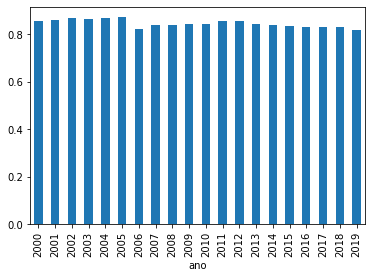

In [14]:
dfst = result_base[result_base.DUMMY_ST_POS08.isin([0])]
dfst1 = dfst[dfst.indicador_simples.isin([0])]

dfst1.groupby('ano')['qtd_empresas_log'].mean().plot.bar()

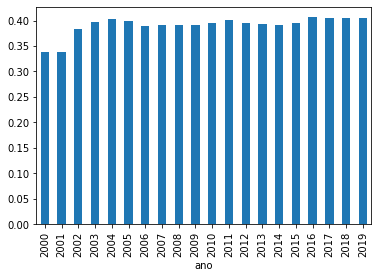

In [15]:
dfst = result_base[result_base.DUMMY_ST_POS08.isin([1])]
dfst1 = dfst[dfst.indicador_simples.isin([1])]
dfst1.groupby('ano')['O_ST_VIN_EMP'].mean().plot.bar()

In [ ]:
# dependent variable = treated dummy + after intervention dummy + affected by * after dummy (+ other variables)
# QTD_EMPRESAS = DUMMY_ST_POS08 + DUMMY_08_09 + DUMMY_ST_POS08*DUMMY_MI_08

In [ ]:
# teste = result_base[result_base['SETOR_COM_ST'].isin([0,1]) & result_base['ano'].isin([2005,2006,2007,2008,2009,2010,2011,2012])]
# teste.to_csv('result_base_completa_05_12.csv')
# !cp result_base_completa_05_12.csv "drive/My Drive/"

# df_modelo_setst = result_base_completa[result_base_completa.SETOR_COM_ST.isin([1])]
# df_modelo_setst1 = df_modelo_setst[result_base_completa.ano.isin([2015,2016])]
# df_modelo_setst1.head()

In [16]:
# df_modelo_setst = result_base[result_base.ano.isin([2006,2007,2008,2009,2010,2011])] 
# [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]
# df_modelo_setst = result_base[result_base.SETOR_COM_ST.isin([1])]
# df_modelo_setst_rpa = df_modelo_setst[df_modelo_setst.indicador_simples.isin([0])]
df_modelo_setst = result_base[result_base['SETOR_COM_ST'].isin([1]) 
&
result_base['ano'].isin([2006,2007,2008,2009,2010,2011]) 
& ~ result_base['indicador_simples'].isin([1])
]
# ~ antes do result para virar notin

# Chaves do modelo (tempo e variável)
# df_modelo = df_modelo_setst.set_index(['cnae_2_municipio','ano'])
df_modelo = df_modelo_setst.set_index(['cnae_2_municipio','ano'])
# df_modelo = df_modelo_setst.set_index(['cnae_2','ano'])

# Constante
df_modelo['const'] = 1

# Interação da variável de intervenção com a temporal (quando passou a estar vigente)
df_modelo['ST_INTERACAO'] = df_modelo['DUMMY_ST_POS08']*df_modelo['DUMMY_MI_08']
df_modelo['O_ST'] = df_modelo['O_ST_QTD_EMP']*df_modelo['DUMMY_MI_08']
df_modelo['D_ST'] = df_modelo['D_ST_QTD_EMP']*df_modelo['DUMMY_MI_08']

In [17]:
df_modelo_setst.head()

,ano,cnae_2,indicador_simples,id_municipio_6,qtd_empresas,rem_med,empregados_ativos,rem_med_log,empregados_ativos_log,qtd_empresas_log,cnae_2_municipio,cnae_1,TRATADA,DESC_CNAE2_5D,ATIVIDADE_CONTA_NACIONAL,DESC_ATIVIDADE,SETOR_COM_ST,ST_CNAE_CNAE,DUMMY_ST_CNAE,DUMMY_ST_PRE08,DUMMY_ST_POS08,SETOR,DUMMY_PRIMARIO,DUMMY_SECUNDARIO,DUMMY_TERCIARIO,PERC_ATIV_ST,DUMMY_MI_08,O_ST_QTD_EMP,D_ST_QTD_EMP,O_ST_REM_EMP,D_ST_REM_EMP,O_ST_VIN_EMP,D_ST_VIN_EMP
2,2007,1512,0,350010,109,550.124032,124.0,6.310144,4.820282,4.691348,1512350010,NaN,NaN,Criação de bovinos,192,"Pecuária, inclusive o apoio à pecuária",1,PÓS 2008,1,0,1,Primário,1,0,0,0.856023,0,0.525097,0.934996,0.448924,0.900783,0.493599,0.922489
32,2007,10813,0,350010,2,1047.192800,25.0,6.953868,3.218876,0.693147,10813350010,NaN,NaN,Torrefação e moagem de café,1093,Outros produtos alimentares,1,SEM ST,0,0,0,Secundário,0,1,0,0.880389,0,0.351413,0.659828,0.298118,0.583878,0.312664,0.637565
48,2007,23303,0,350010,3,1134.866250,8.0,7.034270,2.079442,1.098612,23303350010,NaN,NaN,"Fabricação de artefatos de concreto, cimento, ...",2300,Fabricação de produtos de minerais não-metálicos,1,PÓS 2008,1,0,1,Secundário,0,1,0,0.878769,0,0.368096,0.219200,0.349809,0.202966,0.373469,0.216799
50,2007,10996,0,350010,1,855.674364,55.0,6.751890,4.007333,0.000000,10996350010,NaN,NaN,Fabricação de produtos alimentícios não especi...,1093,Outros produtos alimentares,1,PRÉ 2008,1,1,0,Secundário,0,1,0,0.880389,0,0.351413,0.659828,0.298118,0.583878,0.312664,0.637565
52,2007,1130,0,350010,6,1163.713957,230.0,7.059372,5.438079,1.791759,1130350010,NaN,NaN,Cultivo de cana-de-açúcar,191,"Agricultura, inclusive o apoio à agricultura e...",1,SEM ST,0,0,0,Primário,1,0,0,0.255476,0,0.435967,0.782090,0.397634,0.750617,0.425270,0.783639


In [20]:
# Variável dependente
Y = df_modelo['empregados_ativos_log']
# ST_INTERACAO      -0.0814
# R-squared:                        0.0053

# Y = df_modelo['rem_med_log']
# ST_INTERACAO      -0.0134
# R-squared:                        0.1403

# Y = df_modelo['qtd_empresas_log']
# ST_INTERACAO      -0.0394 
# R-squared:                        0.0038

# Variáveis do modelo de diferença em diferenças (cluster_entity=True) indica que os erros estão clusterizados por CNAE)
dd = ['const','DUMMY_ST_POS08','DUMMY_MI_08','ST_INTERACAO'
# ,'indicador_simples'
,'O_ST_QTD_EMP','D_ST_QTD_EMP'
,'O_ST_REM_EMP','D_ST_REM_EMP'
,'O_ST_VIN_EMP','D_ST_VIN_EMP'
]
dif_in_dif = PanelOLS(Y, df_modelo[dd]).fit(cov_type='clustered',cluster_entity=True)
print(dif_in_dif.summary)

/usr/local/lib/python3.7/dist-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                            PanelOLS Estimation Summary                            
Dep. Variable:     empregados_ativos_log   R-squared:                        0.0555
Estimator:                      PanelOLS   R-squared (Between):             -0.0205
No. Observations:                  94853   R-squared (Within):              -0.0300
Date:                   Sun, Mar 28 2021   R-squared (Overall):              0.0555
Time:                           20:35:27   Log-likelihood                -1.966e+05
Cov. Estimator:                Clustered                                           
                                           F-statistic:                      619.63
Entities:                          23397   P-value                           0.0000
Avg Obs:                          4.0541   Distribution:                 F(9,94843)
Min Obs:                          1.0000                                           
Max Obs:                          6.0000   F-statistic (robust):            